In [1]:
%%time
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import transform

from shapely.geometry import Point, Polygon
import datetime

from io import StringIO
from pathlib import Path, PureWindowsPath
import os
import sys
from functools import partial

# Import custom functions from `scripts` folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from clean_tweets import geometrize_tweets
data_path = Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Datasets/")

Wall time: 994 ms


In [2]:
data_path

WindowsPath('C:/Users/emman/Box/Spring 2020/Displacement Studio/Datasets')

In [3]:
def convert_shapefile_crs(shapefile):
    """
    Convert shapefile CRS to WGS84 (epsg:4326).
    Function may take a while to run.
    Source: https://gis.stackexchange.com/a/127432

    Parameters
    ----------
    shapefile : geopandas.GeoDataFrame

    Returns
    -------
    shapefile : geopandas.GeoDataFrame
        Contains updated 'geometry' column
    """
    in_proj = pyproj.Proj(shapefile.crs)
    out_proj = pyproj.Proj(init='epsg:4326')

    project = partial(
        pyproj.transform,
        in_proj,
        out_proj
    )
    shapefile['geometry'] = [transform(project, geom) for geom in shapefile['geometry']]

    return shapefile

In [4]:
def find_frequencies(series, pat, case=False, ratio=False):
    """
    Find the number (or ratio) of times that a pattern occurs in a list of tweets.

    Parameters
    ----------
    series : pd.Series
        Column of text containing tweets. Must be dtype

    pat : string
        Regular expression to check against `series`.

    case : boolean (optional, default=False)
        If True, comparisons are case-sensitive (e.g. 'pattern' != 'PaTtErN')
        If False, comparisons are case-insensitive. (e.g. 'pattern' == 'PaTtErN')

    ratio : boolean (optional, default=False)
        If True, return the ratio (number_of_matches) / (number_of_tweets).
        If False, return a tuple (number_of_matches, number_of_tweets).

    Returns
    -------
    integer or float

    """
    n = len(series)
    num_matches = series.str.contains(pat, case=case).sum()

    if ratio:
        return num_matches / n
    else:
        return num_matches, n

In [5]:
def assign_home_location(data, uid='u_id', SA2='SA2_MAIN16', date='date', hour='hour',
                         min_tweets=10, min_days=10, min_hours=8):
    """
    Assign a home location for Twitter users and their tweets based on following methodology:

    1. Consider tracts satisfying the following properties:
        - More than `min_tweets` tweets total
        - Sent from more than `min_days` different days
        - Sent from more than `min_hours` different hours of the day
    2. Of the remaining candidates, select the tract with the most tweets

    This function does not guarantee that all Twitter users/tweets will be assigned a home location.
    Some users will not have any tweets that meet the criteria defined above; this will result in a
    missing value (np.NaN) being assigned to the home tract for that user's tweets.


    Parameters
    ----------
    data : pd.DataFrame or gpd.geodataframe.GeoDataFrame
        DataFrame containing the following columns (variables passed into the function):
            - uid : Twitter user ID
            - sa2 : Tract identifier (e.g. tract ID, FIPS code)
            - date : Datetime object containing just the date
                     (year, month, and day; not a full timestamp)
            - hour : Integer containing 24-hour-format hour of tweet

    uid, tract, date, hour : string (optional, default='u_id', 'OBJECTID', 'date', 'hour')
        Column names to extract from `data`; additional details under `data` parameter

    min_tweets : integer (optional, default=10)
        Minimum number of tweets required from a user at a valid tract

    min_days : integer (optional, default=10)
        Minimum number of unique days a user must tweet from a valid tract

    min_hours : integer (optional, default=8)
        Minimum number of unique hours a user must tweet from a valid tract


    Returns
    -------
    pd.Series of length data.shape[0], containing a home location for each tweet.
    Note that this function is not an inplace operation.
    e.g. df['home_tract'] = assign_home_location(df)

    """
    # Note: groupby is done multiple times to save computation time
    home_locations = (
        data
        # More than min_tweets
        .groupby(['u_id', 'SA2_MAIN16']) #will need to edit this to a different code later
        .filter(lambda user_tract: len(user_tract) > min_tweets)

        # More than min_days
        .groupby(['u_id', 'SA2_MAIN16'])  #will need to edit this to a different code later
        .filter(lambda user_tract: user_tract[date].nunique() > min_days)

        # More than min_hours
        .groupby(['u_id', 'SA2_MAIN16'])  #will need to edit this to a different code later
        .filter(lambda user_tract: user_tract[hour].nunique() > min_hours)

        # Extract home location
        .groupby(['u_id', 'SA2_MAIN16'])  #will need to edit this to a different code later
        .size()
        .reset_index(name='count')
        .sort_values(by='count', ascending=False)
        .loc[:, ['u_id', 'SA2_MAIN16']]
        .groupby('u_id')
        .first()
        .loc[:, 'SA2_MAIN16']
    )

    return data[uid].map(home_locations.to_dict())


In [6]:
def summary_stats(data):
    """
    Analyze the following:
        - Number of tweets (printed output)
        - Number of unique users (printed output)
        - Median number of tweets/user (returned output)
        - Number of tweets/user at the 99th percentile (returned output)

    Parameters
    ----------
    data : pd.DataFrame or gpd.GeoDataFrame
        DataFrame containing tweets; must contain column `u_id` for user id

    Returns
    -------
    median_tweets : int or float
        Median number of tweets/user

    pct_99_tweets : int or float
        99th percentile of tweets/user
    """
    # Number of tweets
    print("{} total tweets".format(len(data)))

    # Number of unique users
    print("{} unique users\n".format(data['u_id'].nunique()))

    # Percentiles of tweets/user (median + 99th)
    pct_50_tweets, pct_99_tweets = data.groupby('u_id').size().quantile([.50, .99])
    print("Median number of tweets/user: {} tweets".format(pct_50_tweets))
    print("99th percentile of tweets/user: {} tweets".format(pct_99_tweets))

    return pct_50_tweets, pct_99_tweets


In [7]:
def filter_and_home_assign(data, shapefile, lower, upper):
    """
    Find subset of data to analyze based on lower/upper bounds on tweets/user, 
    then add home locations.
    
    Parameters
    ----------
    data : pd.DataFrame or gpd.GeoDataFrame
        DataFrame containing tweets; must contain column `u_id` for user id
    
    shapefile : gpd.GeoDataFrame
        Shapefile for tracts in tweets location.
        Must be in WGS84 (epsg:4326) format (to align with tweet lat/lon).
    
    lower, upper : int or float
        Lower (inclusive) and upper (exclusive) bounds on tweets/user.
        
    Returns
    -------
    filtered : gpd.GeoDataFrame
        Collection of tweets filtered by lower/upper and with tweet geographies.
        Contains new columns:
            - 'timestamp' : pd.Timestamp for time of tweet published
            - 'date' : date (int) of tweet published
            - 'hour' : 24-hour (int) of tweet published
            - 'home' : name of home location codigo (some may be NaN)
            - 'is_home' : boolean indicating whether tweet was made at home
    """
    # Filter based on lower and upper bound on tweets/user
    filtered = data.groupby('u_id').filter(lambda group: (len(group) >= lower) & (len(group) < upper))
    
    # Geometrize tweets (inplace) based on lat/lon
    filtered = geometrize_tweets(filtered)
    
    # Spatial join with tracts
    filtered = gpd.sjoin(filtered, shapefile, how='left', op='intersects')
    
    # Add datetime
    filtered['timestamp'] = pd.to_datetime(filtered['created_at'] // 1000, unit='s')
    filtered['date'] = filtered['timestamp'].dt.date
    filtered['hour'] = filtered['timestamp'].dt.hour
    
    # Add home location
    filtered['home'] = assign_home_location(filtered, SA2='SA2_MAIN16')
    filtered['is_home'] = filtered['SA2_MAIN16'] == filtered['home']
    
    return filtered

In [8]:
tweets_2013 = pd.read_csv(data_path/'AUST_TWT_2013.csv')

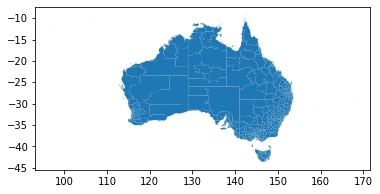

In [9]:
au_shape_sa2 = gpd.read_file('C:\\Users\\emman\\box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\SA2 Shapefiles\\SA2_2016_AUST.dbf')
# Crikey, our area is too big
au_shape_sa2.plot()
# We also need to change the crs 
au_shape_sa2.crs = {'init': 'epsg:4326'}
# have the shapefile only have areas that are in the state of New South Wales, and furthermore, in Greater Sydney
au_shape_sa2 = au_shape_sa2[au_shape_sa2.STE_NAME16 == 'New South Wales']
au_shape_sa2 = au_shape_sa2[au_shape_sa2.GCC_NAME16 == 'Greater Sydney']

In [10]:
tweets_2013.head()

,Unnamed: 0,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,timestamp,date
0,390946,285914740658683904,1.357002e+12,Happy New Year's Day y'all!! #bondibeach #newy...,21872222,Rachel S. Binstock,1.235573e+12,AVID Braves fan,87,ll,AUS,RSBinstock,339,151.273167,-33.893500,POINT (151.27316667 -33.8935),2013-01-01 01:06:00,2013-01-01 00:00:00
1,390948,285919042517217280,1.357003e+12,1st Yum Cha for the year. (@ Fook Yuen Seafood...,17591715,MrSteddy,1.227534e+12,"Husband, Decoder Architect,Technologist, Sailo...",18,ll,AUS,MrSteddy,47,151.180192,-33.795655,POINT (151.18019183 -33.79565543),2013-01-01 01:23:06,2013-01-01 00:00:00
2,390949,285919475499425792,1.357003e+12,DO WE HAVE JARIANA PHOTOS YET!?,434109082,"Hi, I'm Maddie⭐",1.323607e+12,One Direction and The Collective are fabulous....,805,ll,AUS,HiTheCollective,494,150.828376,-33.595224,POINT (150.82837578 -33.59522411),2013-01-01 01:24:49,2013-01-01 00:00:00
3,390951,285920370614206464,1.357004e+12,@wildone069 rock solid Rabbitohs love it !,38649507,Mario Fenech,1.241783e+12,"NRL, Footy Show, thefalcon.com.au NRL employee...",11946,ll,AUS,MarioFenech,20,151.217897,-33.937611,POINT (151.21789651 -33.93761143),2013-01-01 01:28:23,2013-01-01 00:00:00
4,390954,285923605311807490,1.357004e+12,@Swearycat @Bad_Cat_ Also services apartments ...,65283730,Meagan,1.250141e+12,"Former adviser, now working with a health NGO....",365,ll,AUS,maenad01,922,151.223549,-33.875925,POINT (151.22354923 -33.87592472),2013-01-01 01:41:14,2013-01-01 00:00:00


In [11]:
pct_50, pct_99 = summary_stats(tweets_2013)

2083979 total tweets
53485 unique users

Median number of tweets/user: 5.0 tweets
99th percentile of tweets/user: 567.1599999999962 tweets


In [12]:
twt2013 = filter_and_home_assign(tweets_2013, au_shape_sa2, pct_50, pct_99)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


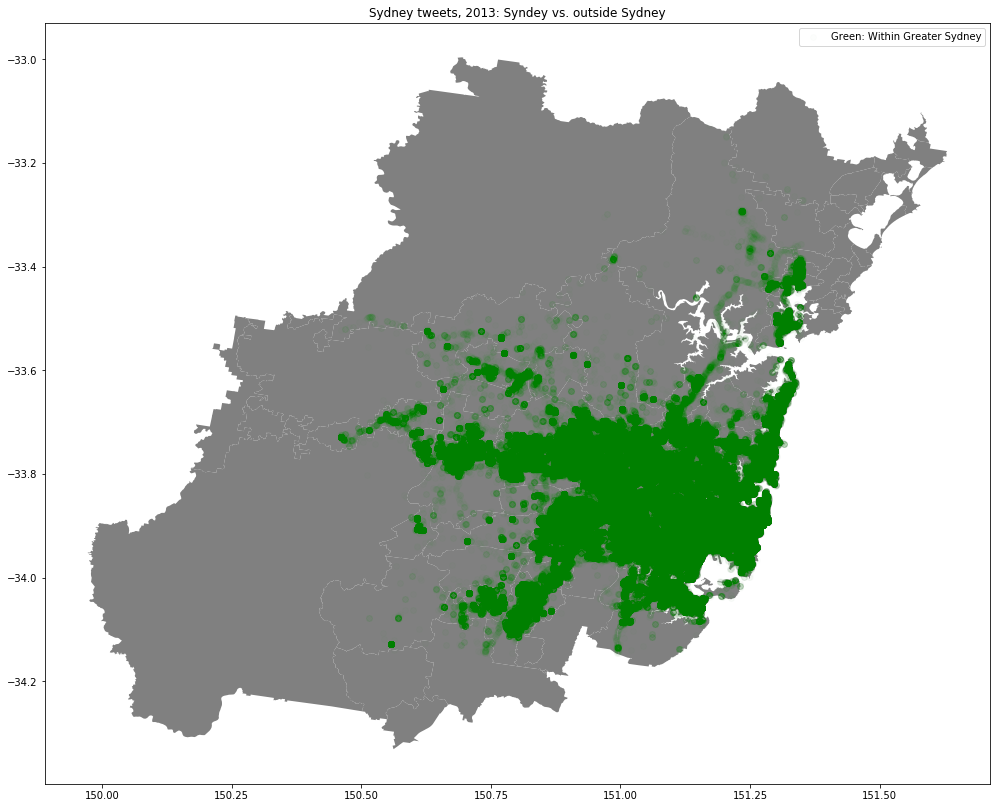

In [13]:
### Plot all 2013 tweets ###
# Green tweets: Joined to an SA2
# Orange tweets: No SA2 Assigned
# Gray: Australia shapefile

fig, ax = plt.subplots(figsize=(20, 14))
au_shape_sa2['geometry'].plot(ax=ax, color='gray')
sample = twt2013.sample(frac=1.00, random_state=42)
sample[~sample['SA2_MAIN16'].isnull()].plot(ax=ax, marker='o', color='green', alpha=0.01, label='Green: Within Greater Sydney')
sample[sample['SA2_MAIN16'].isnull()].plot(ax=ax, marker='o', color='orange', alpha=0.01, label='Orange: Outside Greater Sydney')
plt.legend()
plt.title('Sydney tweets, 2013: Syndey vs. outside Sydney');

From this, we see that we can use [~autwt_2013['SA2_5DIG16'].isnull()] as a filter to select just the tweets in Syndey, which is our area of interest. For all following analyses, we will restrict the population to just the tweets that fall inside Sydney depicted by the shapefile.

Our first summary statistic computes the ratio of tweets that have a home assignment.

In [14]:
num_home_assigned_tweets = (~twt2013.loc[~twt2013['SA2_MAIN16'].isnull(), 'home'].isnull()).sum()
n_tweets = len(twt2013[~twt2013['SA2_MAIN16'].isnull()])

print("{}/{} = {:.2%} of tweets have a home assignment.".format(
    num_home_assigned_tweets, n_tweets, num_home_assigned_tweets / n_tweets
))

910132/1289794 = 70.56% of tweets have a home assignment.


Next, we are interested in the ratio of users that have a home assignment.

In [15]:
num_users_with_home = (~twt2013.loc[~twt2013['SA2_MAIN16'].isnull()].groupby('u_id')['home'].first().isnull()).sum()
n_users = len(twt2013[~twt2013['SA2_MAIN16'].isnull()].groupby('u_id'))

print("{}/{} = {:.2%} of users have a home assignment.".format(
    num_users_with_home, n_users, num_users_with_home / n_users
))

6813/27021 = 25.21% of users have a home assignment.


Lastly, we want to know the ratio of tweets that were made from home (i.e. SA2_5DIG16 and home are equal).

In [16]:
twt2013.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1289794 entries, 0 to 2083978
Data columns (total 34 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   Unnamed: 0         1289794 non-null  int64         
 1   id                 1289794 non-null  int64         
 2   created_at         1289794 non-null  float64       
 3   text               1289794 non-null  object        
 4   u_id               1289794 non-null  int64         
 5   u_name             1289794 non-null  object        
 6   u_created_at       1289794 non-null  float64       
 7   u_description      1289794 non-null  object        
 8   u_followers_count  1289794 non-null  int64         
 9   type               1289794 non-null  object        
 10  c_country          1289794 non-null  object        
 11  u_screen_name      1289794 non-null  object        
 12  u_friends_count    1289794 non-null  int64         
 13  location.lon       

In [17]:
num_tweets_from_home = twt2013.loc[~twt2013['SA2_MAIN16'].isnull(), 'is_home'].sum()

print("{}/{} = {:.2%} of tweets are posted from the home tract.".format(
    num_tweets_from_home, n_tweets, num_tweets_from_home / n_tweets
))

559199/1289794 = 43.36% of tweets are posted from the home tract.


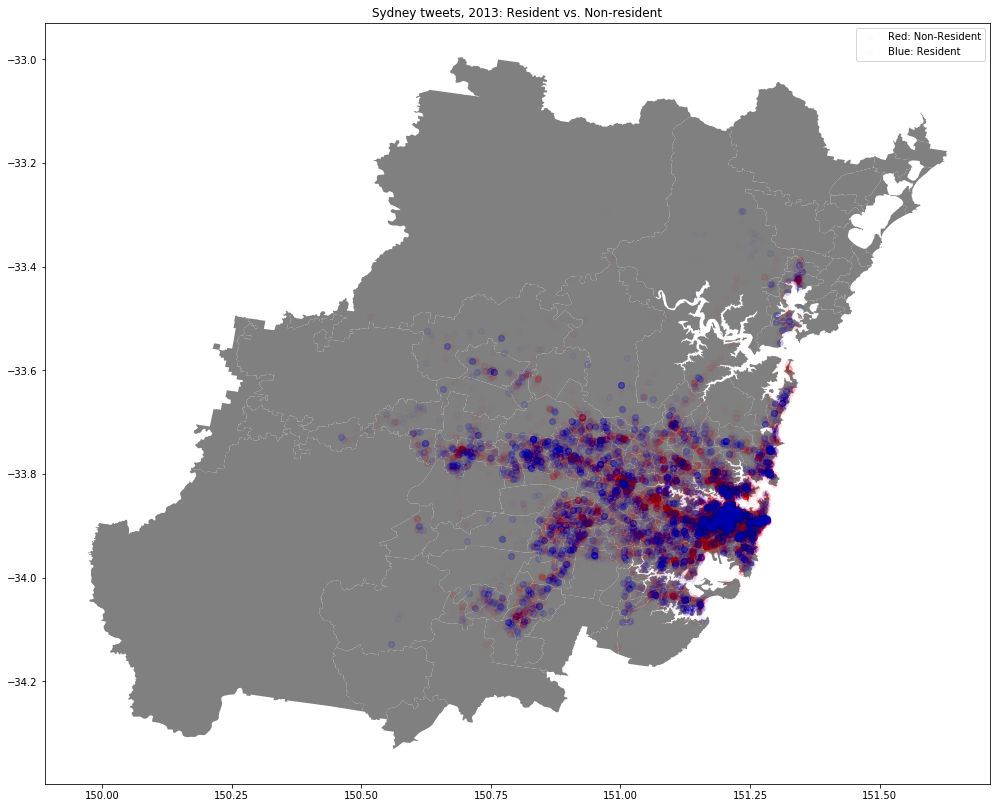

In [18]:
### Plot a 5% sample of 2013 tweets ###
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray: Sydney shapefile

fig, ax = plt.subplots(figsize=(20, 14))

au_shape_sa2['geometry'].plot(ax=ax, color='gray')

sample = twt2013[~twt2013['SA2_MAIN16'].isnull()].sample(frac=0.05, random_state=42)

sample[~sample['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')

sample[sample['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')

plt.legend()
plt.title('Sydney tweets, 2013: Resident vs. Non-resident');

Our analysis concludes with a visual representation of this last information; namely, how are the tweets spread out across the entire metropolitan area of Buenos Aires with respect to residence/nonresidence?

# Saving Output

For future reference, we save an output CSV of all the tweets, spatially joined to the Bogota shapefiles. There are two additional columns:

    home: NaN (missing value) if the tweet user has no home location, else the home tract ('SECU_CCNCT')
    is_home: an indicator (True/False) determining whether home == SECU_CCNCT


In [19]:
twt2013.to_csv(data_path/'au_twt2013_joined.csv.gz', index=False, compression='gzip')